In [57]:
# load model
import gpt2

config, tokenizer, gpt = gpt2.create_gpt2()
model = gpt2.GPT2(config, gpt, verbose=False)

loaded model


In [58]:
model.model.num_parameters()

124439808

In [90]:
from utils import embed_to_distrib, top_vals, format_token

inputs = [
    tokenizer("The capital of Spain is", return_tensors="pt"),
    tokenizer("The capital of Italy is", return_tensors="pt")
]
print(inputs)

res, cache = model(inputs, lambda x: 0, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
res, cache = model(inputs, lambda x: 1, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

[{'input_ids': tensor([[ 464, 3139,  286, 8602,  318]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}, {'input_ids': tensor([[ 464, 3139,  286, 8031,  318]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}]
_Madrid              0.10501430183649063
_the                 0.09496448934078217
_Barcelona           0.07027824968099594
_a                   0.04010051116347313
_now                 0.028243739157915115
_in                  0.02759999968111515
_Spain               0.022992147132754326
_Catalonia           0.01882328651845455
_also                0.018689345568418503
_not                 0.017356840893626213

_Rome                0.15734398365020752
_the                 0.07316114008426666
_Milan               0.046880945563316345
_a                   0.03450039029121399
_now                 0.032002970576286316
_in                  0.023064950481057167
_also                0.022747935727238655
_home                0.019203385338187218
_not                 0.016405237838625908
_Ital

In [91]:
import pandas as pd
from tqdm import tqdm
from functools import partial

layers = config.n_layer
nodes = ["none"]
for l in range(layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')

def per_node_and_position(which, branch):
    tokens = tokenizer.encode(" Madrid Rome")
    data = []
    
    for i, node in enumerate(tqdm(nodes)):
        for j in range(len(inputs[0].input_ids[0])):
            model.cache = {}
            res, cache = model(
                inputs,
                partial(which, node=node, pos=j),
                partial(branch, node=node, pos=j),
                store_cache=False
            )
            distrib = embed_to_distrib(model, res.hidden_states, logits=False)
            for token in tokens:
                data.append({
                    'token': format_token(tokenizer, token),
                    'prob': float(distrib[0][-1][token]),
                    'layer': node,
                    'pos': j,
                    'id': i
                })

    df = pd.DataFrame(data)
    return df

In [92]:
# for this node and position, scrub
def which(path, node, pos):
    if f"{node}.head.pos{pos}" in path or f"{node}.pos{pos}" in path:
        return 1
    return 0

# control branching to only expose positions at the node in question
def branch(path, node, pos):
    if path[-1] == f'{node}': return 'positions'
    if path[-1] == f'{node}.head': return 'positions'
    return False

df = per_node_and_position(which, branch)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.20it/s]


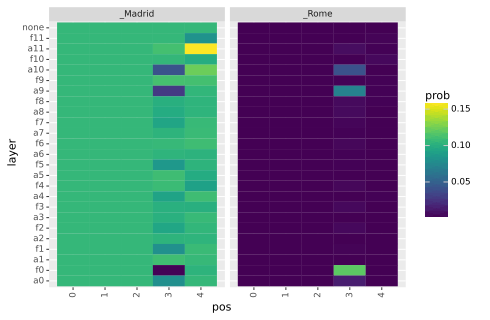

In [93]:
%config InlineBackend.figure_formats = ['svg']

from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: last_token.svg


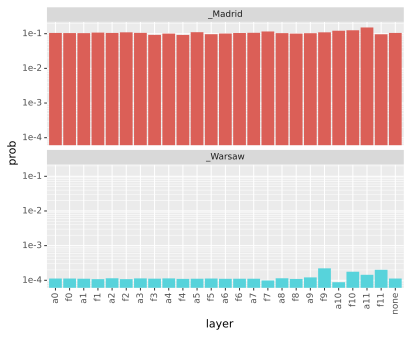

In [63]:
from plotnine import geom_bar, facet_wrap, geom_hline, scale_y_log10, theme

# filtered = df[df['token']=='_Madrid']
filtered = df
filtered = filtered[filtered['pos'] == 4]
# filtered = filtered[~filtered['layer'].str.startswith('f')]
# true = float(filtered[filtered['layer'] == "none"]['prob'])
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
g.save('last_token.svg')
print(g)

In [64]:
print(filtered[filtered['token'] == '_Warsaw'].set_index('layer')['prob'].to_markdown())

| layer   |        prob |
|:--------|------------:|
| none    | 0.000112535 |
| f11     | 0.000200807 |
| a11     | 0.000144351 |
| f10     | 0.000176747 |
| a10     | 8.84012e-05 |
| f9      | 0.000221631 |
| a9      | 0.000121241 |
| f8      | 0.000109633 |
| a8      | 0.000114768 |
| f7      | 9.91858e-05 |
| a7      | 0.000111345 |
| f6      | 0.000111086 |
| a6      | 0.000110849 |
| f5      | 0.000112592 |
| a5      | 0.000111369 |
| f4      | 0.000110255 |
| a4      | 0.000113468 |
| f3      | 0.000111412 |
| a3      | 0.000113571 |
| f2      | 0.000108349 |
| a2      | 0.000114417 |
| f1      | 0.000108117 |
| a1      | 0.000111375 |
| f0      | 0.000112557 |
| a0      | 0.000112535 |


In [68]:
import pandas as pd
from tqdm import tqdm
from IPython import display

layers = config.n_layer
nodes = ["none"]
for l in range(layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')

tokens = tokenizer.encode(" Madrid Warsaw")
data = []
model.cache = {}
for i, node in enumerate(tqdm(nodes)):
    for j in range(len(inputs[0].input_ids[0])):
        def which(path):
            res = len([x for x in path if x.endswith(f'pos{j}')])
            return 1 if res >= 1 else 0

        def branch(path):
            for nod in nodes[:i + 1]:
                if path[-1] == nod and len(path) == 2: return 'positions'
                if path[-1] == f'{nod}.head' and len(path) == 3: return 'positions'
            return False

        res, cache = model(inputs, which, branch, store_cache=False)
        # dot = res.visualise_path()
        # display.display_svg(dot)
        # input()
        distrib = embed_to_distrib(model, res.hidden_states, logits=False)
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': node,
                'pos': j,
                'id': i
            })

df = pd.DataFrame(data)
df[:5]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:50<00:00,  4.41s/it]


,token,prob,layer,pos,id
0,_Madrid,0.105014,none,0,0
1,_Warsaw,0.000113,none,0,0
2,_Madrid,0.105014,none,1,0
3,_Warsaw,0.000113,none,1,0
4,_Madrid,0.105014,none,2,0


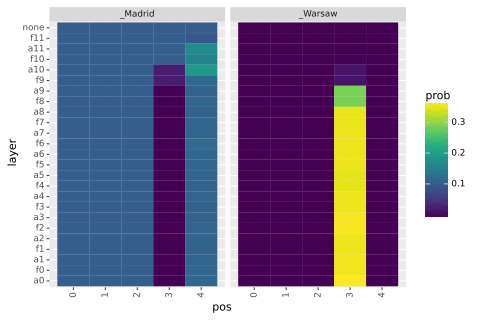

In [69]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: last_token.svg


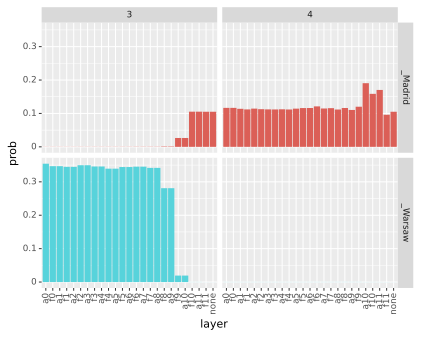

In [70]:
from plotnine import geom_bar, facet_grid, geom_hline, scale_y_log10, theme

# filtered = df[df['token']=='_Madrid']
filtered = df
filtered = filtered[filtered['pos'] >= 3]
# filtered = filtered[~filtered['layer'].str.startswith('f')]
# true = float(filtered[filtered['layer'] == "none"]['prob'])
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none')
         + facet_grid("token~pos"))
g.save('last_token.svg')
print(g)

In [25]:
inputs = [
    tokenizer("The capital of Spain is", return_tensors="pt"),
    tokenizer("The king of Spain is", return_tensors="pt")
]

res, cache = model(inputs, lambda x: 0, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
res, cache = model(inputs, lambda x: 1, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Madrid              0.10501430183649063
_the                 0.09496448934078217
_Barcelona           0.07027824968099594
_a                   0.04010051116347313
_now                 0.028243739157915115
_in                  0.02759999968111515
_Spain               0.022992147132754326
_Catalonia           0.01882328651845455
_also                0.018689345568418503
_not                 0.017356840893626213

_a                   0.08214586228132248
_the                 0.07042139768600464
_not                 0.040079619735479355
_in                  0.025384968146681786
_now                 0.021499773487448692
_an                  0.0175438541918993
_also                0.0140556450933218
_very                0.013201538473367691
_known               0.012925077229738235
_said                0.011115452274680138


In [26]:
import pandas as pd
from tqdm import tqdm

layers = config.n_layer
nodes = ["none"]
for l in range(layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')

tokens = tokenizer.encode(" Madrid a")
data = []

for i, node in enumerate(tqdm(nodes)):
    for j in range(len(inputs[0].input_ids[0])):
        def which(path):
            if f"{node}.head.pos{j}" in path or f"{node}.pos{j}" in path: return 1
            return 0

        def branch(path):
            if path[-1] == f'{node}': return 'positions'
            if path[-1] == f'{node}.head': return 'positions'
            return False

        res, cache = model(inputs, which, branch, store_cache=False)
        distrib = embed_to_distrib(model, res.hidden_states, logits=False)
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': node,
                'pos': j,
                'id': i
            })

df = pd.DataFrame(data)
df[:5]

100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.43it/s]


,token,prob,layer,pos,id
0,_Madrid,0.105014,none,0,0
1,_a,0.040101,none,0,0
2,_Madrid,0.105014,none,1,0
3,_a,0.040101,none,1,0
4,_Madrid,0.105014,none,2,0


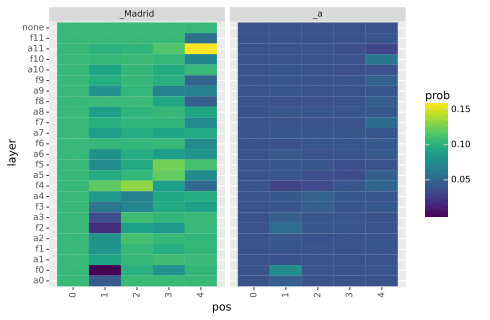

In [28]:
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
g.draw()

In [33]:
inputs = [
    tokenizer("The capital of Spain is", return_tensors="pt"),
    tokenizer("The king of England is", return_tensors="pt")
]

res, cache = model(inputs, lambda x: 0, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
res, cache = model(inputs, lambda x: 1, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Madrid              0.10501430183649063
_the                 0.09496448934078217
_Barcelona           0.07027824968099594
_a                   0.04010051116347313
_now                 0.028243739157915115
_in                  0.02759999968111515
_Spain               0.022992147132754326
_Catalonia           0.01882328651845455
_also                0.018689345568418503
_not                 0.017356840893626213

_a                   0.0895792543888092
_the                 0.065070740878582
_not                 0.04954326152801514
_in                  0.02451072633266449
_now                 0.021554037928581238
_an                  0.017366791144013405
_said                0.013164164498448372
_very                0.012539694085717201
_also                0.010542817413806915
_one                 0.01023358479142189


In [34]:
import pandas as pd
from tqdm import tqdm

layers = config.n_layer
nodes = ["none"]
for l in range(layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')

tokens = tokenizer.encode(" Madrid a")
data = []

for i, node in enumerate(tqdm(nodes)):
    for j in range(len(inputs[0].input_ids[0])):
        def which(path):
            if f"{node}.head.pos{j}" in path or f"{node}.pos{j}" in path: return 1
            return 0

        def branch(path):
            if path[-1] == f'{node}': return 'positions'
            if path[-1] == f'{node}.head': return 'positions'
            return False

        res, cache = model(inputs, which, branch, store_cache=False)
        distrib = embed_to_distrib(model, res.hidden_states, logits=False)
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': node,
                'pos': j,
                'id': i
            })

df = pd.DataFrame(data)
df[:5]

100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.41it/s]


,token,prob,layer,pos,id
0,_Madrid,0.105014,none,0,0
1,_a,0.040101,none,0,0
2,_Madrid,0.105014,none,1,0
3,_a,0.040101,none,1,0
4,_Madrid,0.105014,none,2,0


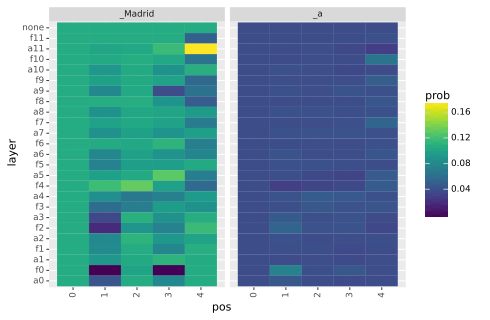

In [35]:
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
g.draw()

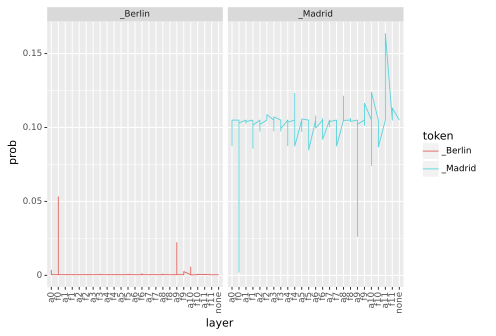

In [12]:
%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_line, aes, facet_wrap, theme, element_text, geom_ribbon

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_line(aes(x='layer', y='prob', color='token', group=1)) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
g.draw()

In [20]:
import pandas as pd
from tqdm import tqdm

layers = config.n_layer
nodes = ["none"]
for l in range(layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')

tokens = tokenizer.encode(" Madrid Berlin")
data = []

for i, node in enumerate(tqdm(nodes)):
    for j in range(len(inputs[0].input_ids[0])):
        def which(path):
            res = 1
            for nod in nodes[:i + 1]:
                for po in range(j + 1):
                    if f"{nod}.head.pos{po}" in path or f"{nod}.pos{po}" in path: res = 0
            return res

        def branch(path):
            for nod in nodes[:i + 1]:
                if path[-1] == nod and len(path) == 2: return 'positions'
                if path[-1] == f'{node}.head' and len(path) == 3: return 'positions'
            return False

        res, cache = model(inputs, which, branch, store_cache=False)
        distrib = embed_to_distrib(model, res.hidden_states, logits=False)
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': node,
                'pos': j,
                'id': i
            })

df = pd.DataFrame(data)
df[:5]

100%|████████████████████████████████████████████████████████████████████████████| 25/25 [01:19<00:00,  3.18s/it]


,token,prob,layer,pos,id
0,_Madrid,0.000337,none,0,0
1,_Berlin,0.052726,none,0,0
2,_Madrid,0.000337,none,1,0
3,_Berlin,0.052726,none,1,0
4,_Madrid,0.000337,none,2,0


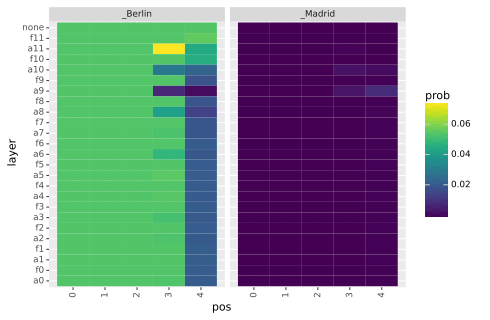

In [21]:
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
g.draw()

In [128]:
inputs = [
    tokenizer("Madrid is the capital of", return_tensors="pt"),
    tokenizer("Berlin is the capital of", return_tensors="pt")
]

res, cache = model(inputs, lambda x: 0, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
res, cache = model(inputs, lambda x: 1, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_the                 0.2153550535440445
_Spain               0.06162545457482338
_a                   0.028562674298882484
_Portugal            0.026089878752827644
_Catalonia           0.022882912307977676
_Morocco             0.0197419635951519
_Colombia            0.017375893890857697
_Brazil              0.010208995081484318
_northern            0.008011970669031143
_one                 0.007774775382131338

_Germany             0.4070201516151428
_the                 0.19737395644187927
_Berlin              0.06362053006887436
_a                   0.030843842774629593
_Switzerland         0.021860549226403236
_Europe              0.016464613378047943
_German              0.01365027017891407
_Bav                 0.009155342355370522
_Hamburg             0.007321305572986603
_Austria             0.006521050352603197


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.99it/s]


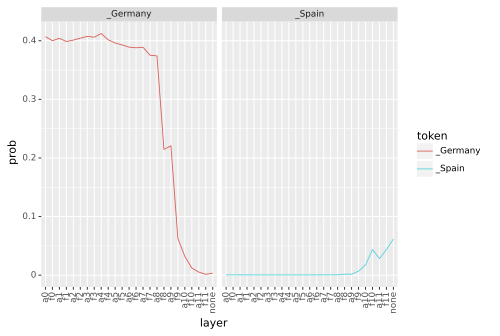

In [129]:
tokens = tokenizer.encode(" Spain Germany")
data = []

for i, node in enumerate(tqdm(nodes)):
    def which(path):
        res = 0
        for nod in nodes[:i + 1]:
            if nod in path: res = 1
        return res

    def branch(path):
        for nod in nodes[:i + 1]:
            if path[-1] == nod and len(path) == 2: return True
        return False

    res, cache = model(inputs, which, branch, store_cache=False)
    distrib = embed_to_distrib(model, res.hidden_states, logits=False)
    for token in tokens:
        data.append({
            'token': format_token(tokenizer, token),
            'prob': float(distrib[0][-1][token]),
            'layer': node,
            'id': i
        })

df = pd.DataFrame(data)
df[:5]

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_line(aes(x='layer', y='prob', color='token', group=1)) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
g.draw()

In [137]:
inputs = [
    tokenizer("Spain has Madrid as its", return_tensors="pt"),
    tokenizer("Spain has Berlin as its", return_tensors="pt")
]

res, cache = model(inputs, lambda x: 0, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
res, cache = model(inputs, lambda x: 1, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_capital             0.2497846484184265
_main                0.05426839739084244
_home                0.03563491255044937
_second              0.017924103885889053
_own                 0.01710747554898262
_official            0.015693791210651398
_primary             0.01525627076625824
_biggest             0.012762369588017464
_new                 0.01180992741137743
_most                0.011529576033353806

_capital             0.37343358993530273
_main                0.04491443559527397
_headquarters        0.040966879576444626
_base                0.02186751365661621
_home                0.01877705194056034
_primary             0.012145409360527992
_official            0.012088833376765251
_own                 0.011496060527861118
_"                   0.010912188328802586
_first               0.010568873025476933


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.02it/s]


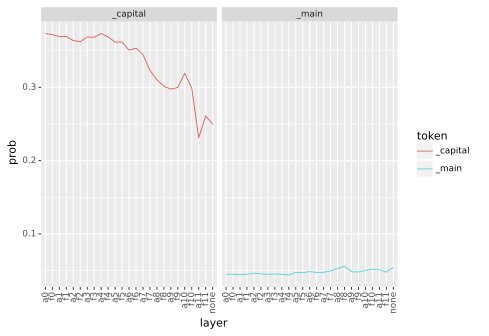

In [138]:
tokens = tokenizer.encode(" capital main")
data = []

for i, node in enumerate(tqdm(nodes)):
    def which(path):
        res = 0
        for nod in nodes[:i + 1]:
            if nod in path: res = 1
        return res

    def branch(path):
        for nod in nodes[:i + 1]:
            if path[-1] == nod and len(path) == 2: return True
        return False

    res, cache = model(inputs, which, branch, store_cache=False)
    distrib = embed_to_distrib(model, res.hidden_states, logits=False)
    for token in tokens:
        data.append({
            'token': format_token(tokenizer, token),
            'prob': float(distrib[0][-1][token]),
            'layer': node,
            'id': i
        })

df = pd.DataFrame(data)
df[:5]

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_line(aes(x='layer', y='prob', color='token', group=1)) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
g.draw()